### Approach for Time Series Forecasting

In [4]:
#importing libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#reading the data
df=pd.read_csv('bitcoin_price_historical_data.csv')
df.head()

,Months,Price
0,1,217.4
1,2,255.7
2,3,244.3
3,4,236.1
4,5,228.7


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
Months    32 non-null int64
Price     32 non-null float64
dtypes: float64(1), int64(1)
memory usage: 592.0 bytes


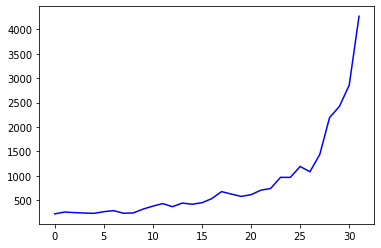

In [5]:
#plotting the data 
plt.plot(df.iloc[:,1],c='b')
plt.show()

In [13]:
#Check Stationarity of a Time Series
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries,wndw):
    
    #Determing rolling statistics
    rolmean = pd.DataFrame.rolling(timeseries, window=wndw).mean()
    rolstd = pd.DataFrame.rolling(timeseries, window=wndw).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

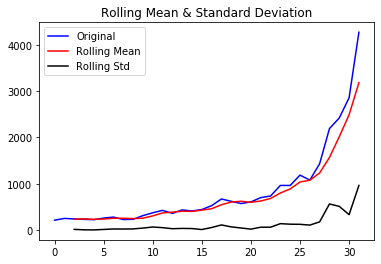

Results of Dickey-Fuller Test:
Test Statistic                  1.162080
p-value                         0.995713
#Lags Used                     10.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [15]:
test_stationarity(df.iloc[:,1],3)

### Estimating & Eliminating Trend

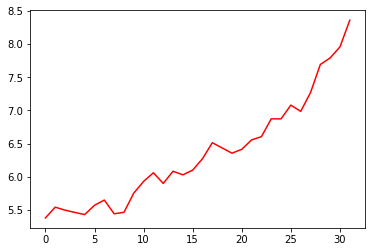

In [18]:
#transformation
#plt.plot(df.iloc[:,1],c='b',label='Original')
plt.plot(np.log(df.iloc[:,1]),c='r',label='LogScale')

__Removing trend from a Time Series__
Aggregation – taking average for a time period like monthly/weekly averages
Smoothing – taking rolling averages
Polynomial Fitting – fit a regression model

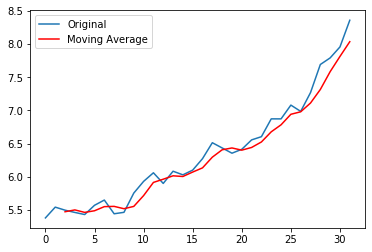

In [21]:
#Moving average
moving_avg = pd.DataFrame.rolling(np.log(df.iloc[:,1]),3).mean()
plt.plot(np.log(df.iloc[:,1]),label='Original')
plt.plot(moving_avg, color='red',label='Moving Average')
plt.legend(loc='best')
plt.show()

In [22]:
#Removing Moving Average value from the original Time Series to remove trend.
ts_log_moving_avg_diff = np.log(df.iloc[:,1]) - moving_avg
ts_log_moving_avg_diff.head(12)

0          NaN
1          NaN
2     0.023683
3    -0.037964
4    -0.032610
5     0.082294
6     0.099094
7    -0.111404
8    -0.054328
9     0.200463
10    0.214090
11    0.145064
Name: Price, dtype: float64

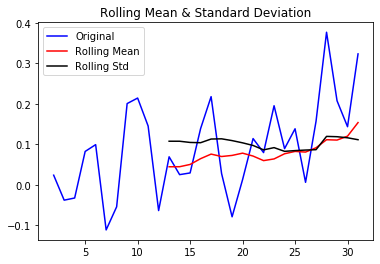

Results of Dickey-Fuller Test:
Test Statistic                  0.864160
p-value                         0.992604
#Lags Used                      8.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [39]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff,12)

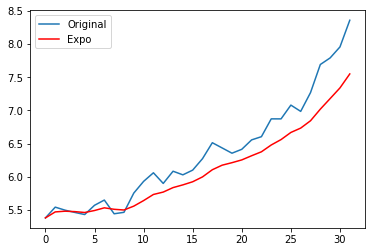

In [26]:
#exponentially weighted moving average
expwighted_avg = pd.DataFrame.ewm(np.log(df.iloc[:,1]), halflife=3).mean()
plt.plot(np.log(df.iloc[:,1]),label='Original')
plt.plot(expwighted_avg, color='red',label='Expo')
plt.legend(loc='best')
plt.show()

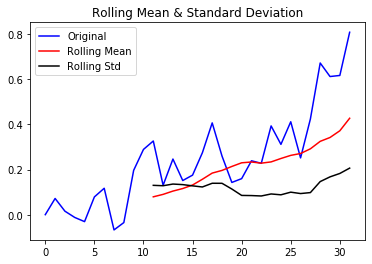

Results of Dickey-Fuller Test:
Test Statistic                  0.942116
p-value                         0.993616
#Lags Used                      9.000000
Number of Observations Used    22.000000
Critical Value (1%)            -3.769733
Critical Value (5%)            -3.005426
Critical Value (10%)           -2.642501
dtype: float64


In [38]:
#Removing Exponential Average value from the original Time Series to remove trend.
ts_log_ewma_diff = np.log(df.iloc[:,1]) - expwighted_avg
test_stationarity(ts_log_ewma_diff,12)

__Eliminating Trend and Seasonality__
Differencing – taking the differece with a particular time lag
Decomposition – modeling both trend and seasonality and removing them from the model.

### Differencing

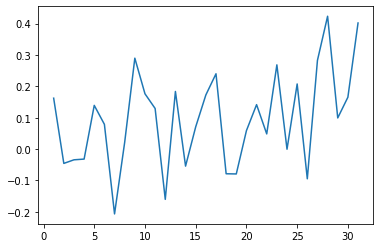

In [31]:
ts_log_diff = np.log(df.iloc[:,1]) - np.log(df.iloc[:,1]).shift()
plt.plot(ts_log_diff)

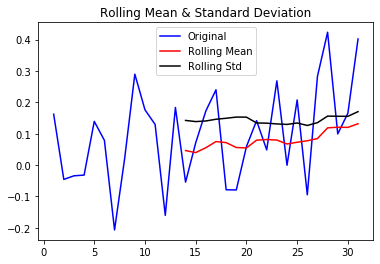

Results of Dickey-Fuller Test:
Test Statistic                  0.470065
p-value                         0.983934
#Lags Used                      8.000000
Number of Observations Used    22.000000
Critical Value (1%)            -3.769733
Critical Value (5%)            -3.005426
Critical Value (10%)           -2.642501
dtype: float64


In [37]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff,14)

### Decomposing

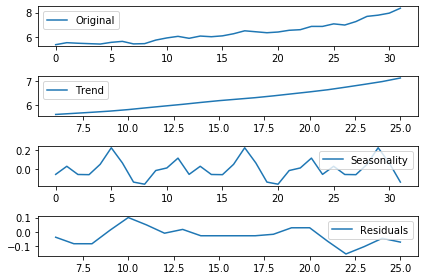

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(df.iloc[:,1]),freq=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(np.log(df.iloc[:,1]), label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

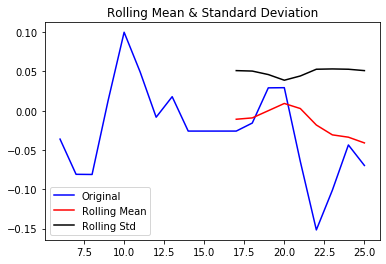

Results of Dickey-Fuller Test:
Test Statistic                  1.531449
p-value                         0.997637
#Lags Used                      8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


In [46]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose,12)

### Forecasting a Time Series

#### ARIMA
ARIMA(p,d,q)
* __Number of AR (Auto-Regressive) terms (p):__ AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
* __Number of MA (Moving Average) terms (q):__ MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
* __Number of Differences (d):__ These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

* __Autocorrelation Function (ACF):__ It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
* __Partial Autocorrelation Function (PACF):__ This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [47]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [48]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

C:\Users\91801\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Autocorrelation Function')

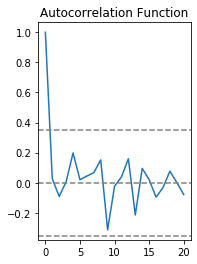

In [49]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

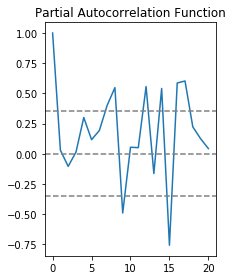

In [50]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [51]:
from statsmodels.tsa.arima_model import ARIMA

Text(0.5, 1.0, 'RSS: nan')

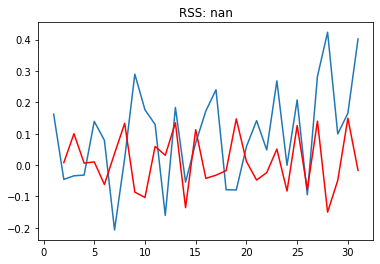

In [96]:
#AR
model = ARIMA(np.log(df.iloc[:,1]), order=(1, 2, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

Text(0.5, 1.0, 'RSS: nan')

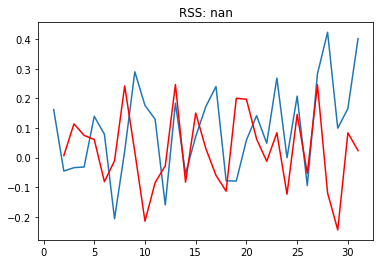

In [97]:
#MA
model = ARIMA(np.log(df.iloc[:,1]), order=(0, 2, 1)  )
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

Text(0.5, 1.0, 'RSS: nan')

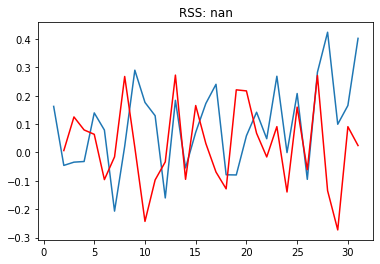

In [98]:
model = ARIMA(np.log(df.iloc[:,1]), order=(1, 2, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [99]:
#Taking it back to original scale
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

2    0.006624
3    0.125120
4    0.079327
5    0.063891
6   -0.095641
dtype: float64

In [100]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

2    0.006624
3    0.131744
4    0.211071
5    0.274961
6    0.179321
dtype: float64

In [101]:
df.head()

,Months,Price
0,1,217.4
1,2,255.7
2,3,244.3
3,4,236.1
4,5,228.7


In [102]:
df.iloc[:,0].head()

0    1
1    2
2    3
3    4
4    5
Name: Months, dtype: int64

In [103]:
predictions_ARIMA_log = pd.Series(df.iloc[:,0], index=df.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

0    1.000000
1    2.000000
2    3.006624
3    4.131744
4    5.211071
dtype: float64

Text(0.5, 1.0, 'RMSE: 32377250282396.4375')

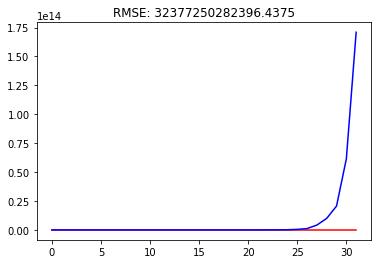

In [104]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df.iloc[:,1],c='red')
plt.plot(predictions_ARIMA,c='blue')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-(df.iloc[:,1]))**2)/len(df)))

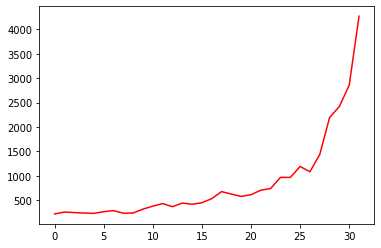

In [88]:
plt.plot(df.iloc[:,1],c='red')